# Forecasting Lorenz system using RNN seq2seq technique
May 13, 2019. Guorui Shen, guorui233@outlook.com.

- RNN adopted in this notebook is built on Tensorflow.

Detailed information:
+ Time series considered in this demo is $u_i = \left[x(t_i), y(t_i), z(t_i)\right]$, sampled from Lorenz system
\begin{align}
&\frac{dx}{dt}=\sigma(y-x),\\
&\frac{dy}{dt}=x(\rho-z)-y,\\
&\frac{dz}{dt}=xy-\beta z.
\end{align}
+ Neural Network (NN) we used in here contains an encoder and a decoder. Features and labels are chosen such that
$$NN(u_{k-\text{timesteps}}, \cdots, u_{k-2}, u_{k-1}) = u_{k},u_{k+1}, \cdots, u_{k+\text{timesteps}-1}$$
i.e. NN maps from past observations to the same amount of future next observations.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## 1 Original data

In [2]:
num_discard = 2500
lrz = sio.loadmat('Lorenz.mat')
data = lrz['states'][num_discard:,:]
T = lrz['t'][0][num_discard:]
print(len(data), len(data[0]))

(3500, 3)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

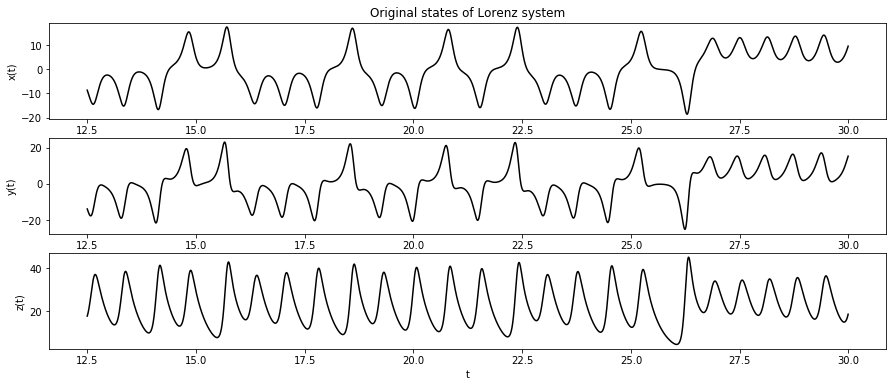

In [3]:
ylabel = ['x(t)', 'y(t)', 'z(t)']
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Original states of Lorenz system')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(T, data[:, i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

## 2 Pick up needed features and labels

In [4]:
timesteps = 50
batch_size = 50
output_dim = input_dim = 3
num_train = 1200 # number of examples for training
num_test = 2000

In [5]:
# features and labels for training model
features_train = np.empty(shape=(0, timesteps, input_dim))
labels_train = np.empty(shape=(0, timesteps, output_dim))
for i in range(num_train):
    features_train = np.vstack((features_train, data[i:i+timesteps, :].reshape(-1,timesteps,input_dim)))
    labels_train = np.vstack((labels_train, data[i+timesteps:i+2*timesteps, :].reshape(-1,timesteps,output_dim)))
print(features_train.shape, labels_train.shape)

((1200, 50, 3), (1200, 50, 3))


In [6]:
# features and labels for testing model
i = num_train
features_test_input = data[i:i+timesteps, :].reshape(timesteps,1,input_dim)
labels_test = data[i+timesteps:i+timesteps+num_test, :]
print(features_test_input.shape, labels_test.shape)

# for plotting
T_train = T[:i+timesteps]
T_test = T[i+timesteps:i+timesteps+num_test]

((50, 1, 3), (2000, 3))


In [7]:
# Internal neural network parameters
hidden_dim = 100  # Count of hidden neurons in the recurrent units. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
num_iter = 10000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5   # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

## 3 Define the seq2seq neural network

<img src="https://www.tensorflow.org/images/basic_seq2seq.png" />

Comparatively to what we see in the image, our neural network deals with signal rather than letters. Also, we don't have the feedback mechanism yet. 

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Encoder input: (timesteps, batch_size, input_dim)
encoder_input = [
    tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
       for t in range(timesteps)]

# Decoder input: (timesteps, batch_size, output_dim)
decoder_input = [ tf.zeros_like(encoder_input[0], dtype=np.float32, name="GO") ] + encoder_input[:-1]

# expected outputs: (timesteps, batch_size, output_dim)
expected_output = [
    tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_output".format(t))
      for t in range(timesteps)]

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(hidden_dim), tf.contrib.rnn.BasicRNNCell(hidden_dim)])
# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(hidden_dim), tf.contrib.rnn.GRUCell(hidden_dim)])
# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(hidden_dim), tf.contrib.rnn.BasicLSTMCell(hidden_dim)])
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_dim), tf.contrib.rnn.LSTMCell(hidden_dim)])

# This model first runs an RNN to encode encoder_inputs into a state vector, then runs decoder, initialized
# with the last encoder state, on decoder_inputs. Encoder and decoder use the same RNN cell type, but don't 
# share parameters.
# 
# dec_outputs is a list with length "timesteps" whose element has shape of [batch_size, hidden_dim]. 
# dec_state: [batch_size, hidden_dim].
decoder_outputs, decoder_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(
    encoder_input,
    decoder_input,
    cell)

In [9]:
w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
b_out = tf.Variable(tf.random_normal([output_dim]))

# (timesteps, batch_size, output_dim)
predictor = [tf.matmul(i, w_out) + b_out for i in decoder_outputs]

In [10]:
# Training loss and optimizer
loss = 0
for _y, _Y in zip(predictor, expected_output):
    loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    
optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
train_op = optimizer.minimize(loss)

## 4 Train the neural network

In [11]:
def next_batch(x, y, batch_size):
    N = x.shape[0]
    batch_indices = np.random.permutation(N)[:batch_size]
    return x[batch_indices], y[batch_indices]

# Training
train_losses = []
sess.run(tf.global_variables_initializer())
for t in range(0, num_iter+1):

    # both batch_features_tmp and batch_labels_tmp are of the shape: (batch_size, timesteps, output_dim)
    batch_features_tmp, batch_labels_tmp = next_batch(features_train, labels_train, batch_size)
    
    # both batch_features and batch_labels are of the shape: (timesteps, batch_size, output_dim)
    batch_features = batch_features_tmp.transpose((1,0,2))
    batch_labels = batch_labels_tmp.transpose((1,0,2))
    
    feed_dict = {encoder_input[t]: batch_features[t] for t in range(timesteps)}
    feed_dict.update({expected_output[t]: batch_labels[t] for t in range(timesteps)})
    _, train_loss = sess.run([train_op, loss], feed_dict)
    
    train_losses.append(train_loss)
    if t%500==0:
        print("Training step {}, loss is {:.6f}".format(t, train_loss))
print('Training process finished!')

Training step 0, loss is 1116293.750000
Training step 500, loss is 1422.843872
Training step 1000, loss is 414.130859
Training step 1500, loss is 334.130341
Training step 2000, loss is 301.021698
Training step 2500, loss is 274.099640
Training step 3000, loss is 314.891632
Training step 3500, loss is 323.396973
Training step 4000, loss is 187.110840
Training step 4500, loss is 255.951523
Training step 5000, loss is 160.941086
Training step 5500, loss is 79.817802
Training step 6000, loss is 121.472458
Training step 6500, loss is 191.742401
Training step 7000, loss is 35.225960
Training step 7500, loss is 25.037973
Training step 8000, loss is 196.663818
Training step 8500, loss is 83.618645
Training step 9000, loss is 31.082281
Training step 9500, loss is 61.473114
Training step 10000, loss is 288.819916
Training process finished!


Text(0,0.5,u'training error')

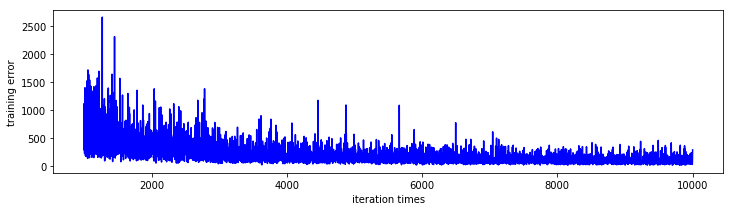

In [12]:
plt.figure(figsize=(12,3))
plt.plot(range(1000, num_iter+1), train_losses[1000:], 'b-')
plt.xlabel('iteration times')
plt.ylabel('training error')

## 5 Predict future values

In [13]:
results = np.empty((0,output_dim))
for t in range(num_test/timesteps):
    feed_dict = {encoder_input[t]: features_test_input[t] for t in range(timesteps)}
    features_test_input = sess.run(predictor, feed_dict)
    results = np.vstack((results, np.array(features_test_input).reshape(timesteps, output_dim)))
print(results.shape)

(2000, 3)


In [14]:
print(labels_test.shape)

(2000, 3)


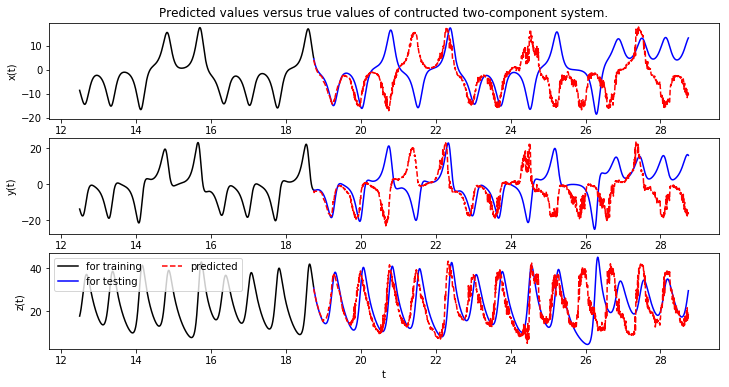

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of contructed two-component system.')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(T_train, data[:num_train+timesteps, i], 'k-', \
             T_test, labels_test[:,i], 'b-', T_test, results[:,i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["for training","for testing", "predicted"], loc = 0, ncol = 2)

In [16]:
sess.close()